# Aнализ активности студентов онлайн курса 

## Описание данных:

[**events_train.csv**](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами  
step_id - id стэпа;  
user_id - анонимизированный id юзера;  
timestamp - время наступления события в формате unix date;    
action - событие, возможные значения:  
* discovered - пользователь перешел на стэп,  
* viewed - просмотр шага,  
* started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага,  
* passed - удачное решение практического шага.  

[**submissions_train.csv**](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям
step_id - id стэпа,  
timestamp - время отправки решения в формате unix date,  
submission_status - статус решения,  
user_id - анонимизированный id юзера.

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
# https://stepik.org/media/attachments/course/4852/event_data_train.zip
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
# https://stepik.org/media/attachments/course/4852/submissions_data_train.zip
submission_data = pd.read_csv('submissions_data_train.csv')
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [7]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

In [8]:
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')
submission_data['day'] = submission_data.date.dt.date
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


## Data exploration

<Axes: xlabel='day'>

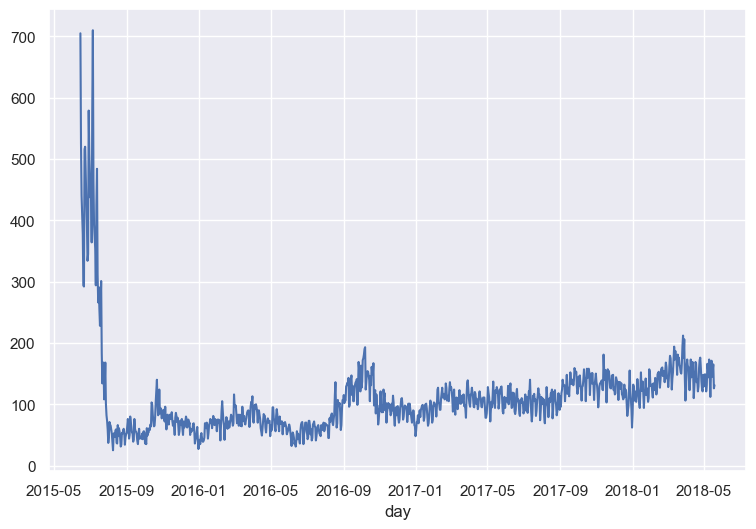

In [9]:
# распределение активных пользователей по дням
events_data.groupby('day').user_id.nunique().plot()

In [10]:
# выполненные пользователями действия на курсе
users_event_data = events_data.pivot_table(index='user_id', 
    columns='action', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0).reset_index()

users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<Axes: >

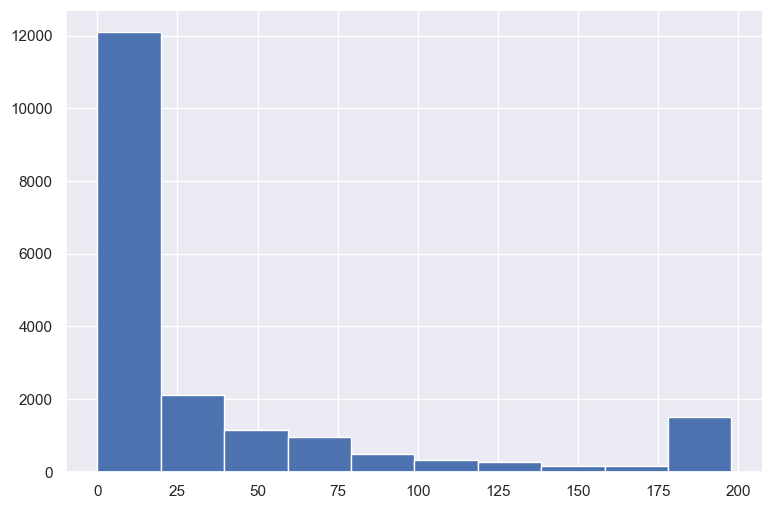

In [11]:
users_event_data.discovered.hist()

In [12]:
# отправленные пользователями решения
users_scores = submission_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Перерывы в днях совершенные пользователями во время прохождения курса

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [14]:
# уникальные дни, в которые пользователь проходил курс
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [15]:
# разница между ближайшими днями
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [16]:
gaps_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gaps_data = pd.Series(np.concatenate(gaps_data, axis = 0))
gaps_data = gaps_data / (24 * 60 * 60)
gaps_data

0       0.994144
1       1.002593
2       1.000012
3       8.996343
4       3.996470
         ...    
560     5.994340
561    15.999433
562     2.999514
563     1.000428
564    42.007384
Length: 565, dtype: float64

<Axes: >

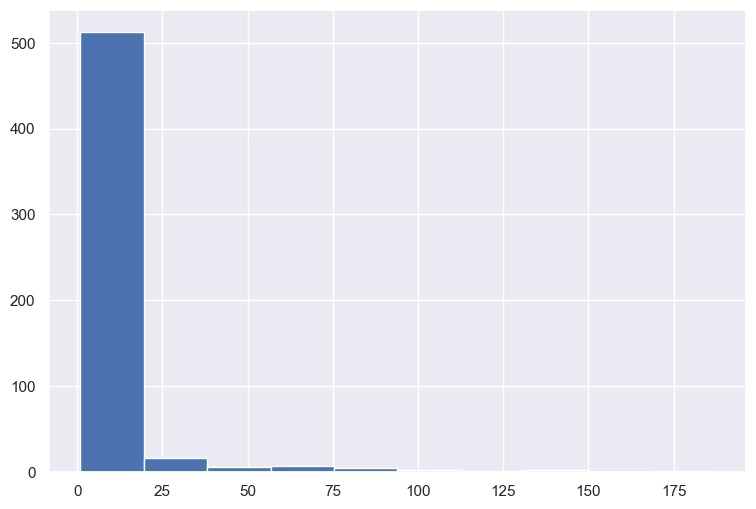

In [17]:
# отсекаются выбросы по оси x
gaps_data[gaps_data < 200].hist()

In [18]:
# только 5% пользователей возвращаются на курс после перерыва в 60 дней
print('95 quantile =',gaps_data.quantile(0.95))
# 90% пользователей прерываются максимум на 15 полных дней
print('90 quantile =',gaps_data.quantile(0.90))

95 quantile = 59.60039351851842
90 quantile = 15.203456018518564


### Определение пользователей, которые бросили курс

In [19]:
# если человек не получил сертификат и отсутствует больше 30 дней, то считается что он бросил курс.

In [20]:
# последнее действие пользователя на курсе
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [21]:
final_day = users_data.last_timestamp.max()
drop_out_threshold = 30 * 24 * 60 * 60 # 30 дней

In [22]:
# определение пользователей, не заходивших более 30 дней
users_data['is_gone_user'] = (final_day - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [23]:
# количество правильных/неправильных ответов пользователя
users_scores.head(3)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2


In [24]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data.fillna(0, inplace=True)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [25]:
# активность пользователя на курсе
users_event_data.head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192


In [26]:
users_data = users_data.merge(users_event_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [27]:
# количество актвных дней, которые пользователь провел на курсе
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head(3)

,user_id,day
0,1,1
1,2,2
2,3,7


In [28]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [29]:
# проверка на потерю данных
print(events_data.user_id.nunique())
print(users_data.user_id.nunique())

19234
19234


In [30]:
# пользователи прошедшие курс (170 - число баллов, необходимых для получения сертификата)
users_data['passed_corse'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [31]:
# сравнение не прошедших/ прошедших курс
users_data.groupby('passed_corse').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corse,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [32]:
# доля не прошедших/ прошедших курс
users_data['passed_corse'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_corse, dtype: float64

## Можно ли, анализируя поведение пользователя за первые несколько дней, предсказать его поведение на курсе

20.0

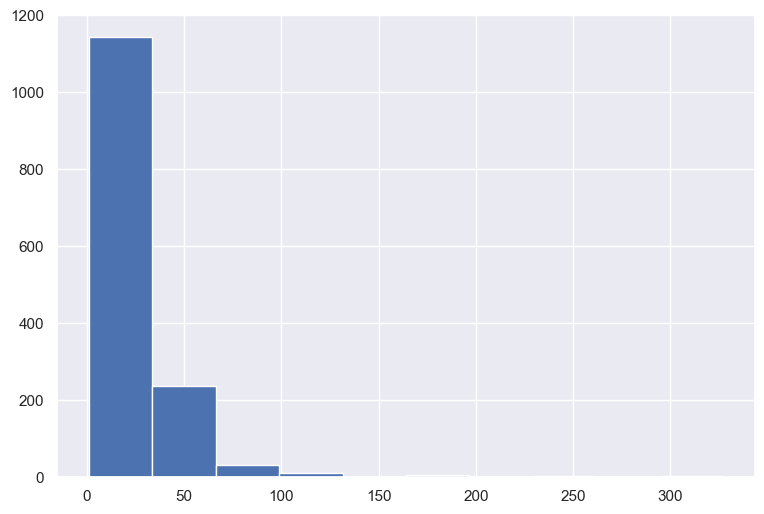

In [33]:
# за какое количество дней пользователи проходят курс
users_data[users_data.passed_corse].day.hist()
users_data[users_data.passed_corse].day.median()

In [34]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [35]:
# для каждого пользователя группируются события, которые были произведены в течении 3 дней с поступления на курс

In [36]:
# первый день, когда пользователь совершил активное действие на курсе
user_min_time = events_data.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'min'}) \
        .rename({'timestamp': 'min_timestamp'}, axis=1)

users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [37]:
# Отбор первого события пользователя на курсе + 3 суток
# Долгий вариант

"""from tqdm import notebook

events_data_train = pd.DataFrame()

for user_id in notebook.tqdm(users_data.user_id):
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_threshold = min_user_time + 3 * 24 * 60 * 60
     
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
    
    events_data_train = pd.concat([events_data_train, user_events_data])  # вместо .append()
    
events_data_train.head()"""

'from tqdm import notebook\n\nevents_data_train = pd.DataFrame()\n\nfor user_id in notebook.tqdm(users_data.user_id):\n    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()\n    time_threshold = min_user_time + 3 * 24 * 60 * 60\n     \n    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]\n    \n    events_data_train = pd.concat([events_data_train, user_events_data])  # вместо .append()\n    \nevents_data_train.head()'

In [38]:
events_data_train = pd.DataFrame()

In [39]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str) 
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [40]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [41]:
# максимальное значение времени, после которого данные не будут использоваться
user_learning_time_threshold = (user_min_time.user_id.map(str) + '_' + 
                               (user_min_time.min_timestamp + learning_time_threshold).map(str))
user_learning_time_threshold.head() 

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [42]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold 
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [43]:
events_data.shape # проверяем чтобы ничего не отвалилось

(3480703, 7)

In [44]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [45]:
events_data.shape # проверяем чтобы ничего не отвалилось

(3480703, 8)

In [46]:
# Отбирается каждый пользователь для которого выполнение каждого действия вписывается в нужный диапазон времени
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [47]:
events_data_train.groupby('user_id').day.nunique().max() # проверяем что уникальное число не больше 4 дней

4

In [48]:
# то же самое для submission data
submission_data['users_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submission_data_train = submission_data[submission_data.users_time <= submission_data.user_learning_time_threshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

## Подготовка X и y

In [49]:
# данные, за выполненные пользователем за первые 3 дня
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index()
print(X.shape)
X.head()

(8913, 2)


,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [53]:
# Сколько степов пользователь прошел/попробовал пройти
steps_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame()\
    .reset_index().rename(columns={'step_id': "steps_tried"})
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [56]:
# количество правильных/неправильных ответов пользователя
users_scores = submission_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id',
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [57]:
# количество просмотренных пользователем степов
viewed_steps = events_data_train.pivot_table(index='user_id',
                                          columns='action',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index()[['user_id','viewed']]
viewed_steps.head()

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1


In [58]:
X = X.merge(steps_tried, on='user_id', how='outer')
X = X.merge(users_scores, on='user_id', how='outer')
# коэффициент правильных ответов
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X = X.merge(viewed_steps, on='user_id', how='outer')
print(X.shape)
X.head()

(19234, 7)


,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [59]:
X = X.fillna(0)

In [60]:
users_data.head()
# Берем данные о том, закончил ли пользователь курс успешно и покинул ли он курс

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [61]:
X = X.merge(users_data[['user_id','passed_corse', 'is_gone_user']], on='user_id', how='outer')
print(X.shape)
X.head()

(19234, 9)


,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [62]:
# отбрасываем данные о пользователях, которые начали курс, но еще не бросили его
X = X[~((X.is_gone_user == False) & (X.passed_corse == False))] # выбрасываем всех False, False (~ - знак отрицания)
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [63]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [64]:
# определяем целевую переменную y - как passed_course
y = X.passed_corse.map(int)
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_corse, dtype: int64

In [65]:
X = X.drop(['passed_corse', 'is_gone_user'], axis=1)
X.head()

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [66]:
# делаем индексом айди пользователя, чтобы не мешался при вычислении
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X.head()

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


## Обучение дерева решений и выбор наилучших параметров

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

In [68]:
dt = DecisionTreeClassifier()
dt_param = {'criterion': ['gini', 'entropy'],
         'max_depth': range(1,11),
         'min_samples_split': range(2,11),
         'min_samples_leaf': range(1,11)}

In [69]:
grid_search_cv_clf = GridSearchCV(dt, param_grid=dt_param, cv=5)
grid_search_cv_clf.fit(X, y)
best_tree = grid_search_cv_clf.best_estimator_
best_tree

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state=42)

In [71]:
best_tree.fit(X_train, y_train)
best_tree_score = best_tree.score(X_test,y_test)
print('Score =', np.round(best_tree_score, 3))

y_pred = best_tree.predict(X_test)

best_tree_precision = precision_score(y_true=y_test, y_pred=y_pred)
print('Precision =', np.round(best_tree_precision, 3))

best_tree_recall = recall_score(y_true=y_test, y_pred=y_pred)
print('Recall =', np.round(best_tree_recall, 3))

best_tree_f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 =', np.round(best_tree_f1, 3))

best_tree_cross_val_mean = cross_val_score(best_tree,X_train,y_train,cv=4).mean()
print('Cross_val_mean =', np.round(best_tree_cross_val_mean, 3))

print('Best_params:', grid_search_cv_clf.best_params_)

Score = 0.93
Precision = 0.464
Recall = 0.167
F1 = 0.246
Cross_val_mean = 0.917
Best_params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


### Определение качества дерева решений

In [72]:
y_pred_prob = best_tree.predict_proba(X_test)

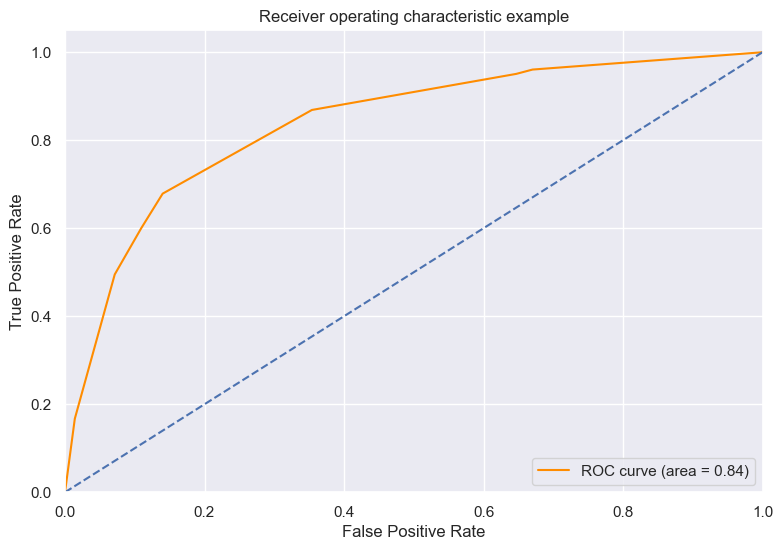

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Логистическая регрессия

In [74]:
lr_clf = LogisticRegressionCV(cv=5)

In [75]:
lr_clf.fit(X_train, y_train)
lr_score = lr_clf.score(X_test,y_test)
print('Score =', np.round(lr_score, 3))

y_pred = lr_clf.predict(X_test)

lr_precision = precision_score(y_true=y_test, y_pred=y_pred)
print('Precision =', np.round(lr_precision, 3))

lr_recall = recall_score(y_true=y_test, y_pred=y_pred)
print('Recall =', np.round(lr_recall, 3))

lr_f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 =', np.round(lr_f1, 3))

lr_cross_val_mean = cross_val_score(lr_clf,X_train,y_train,cv=4).mean()
print('Cross_val_mean =', np.round(lr_cross_val_mean, 3))

print(lr_clf.coef_)

print(lr_clf.intercept_)

Score = 0.932
Precision = 0.495
Recall = 0.164
F1 = 0.246
Cross_val_mean = 0.92
[[ 5.14837972e-01 -1.50112508e-02  8.83337597e-02  1.51425537e-03
   3.67536891e-01 -2.45286823e-04]]
[-3.64397342]


In [76]:
y_pred_prob = lr_clf.predict_proba(X_test)

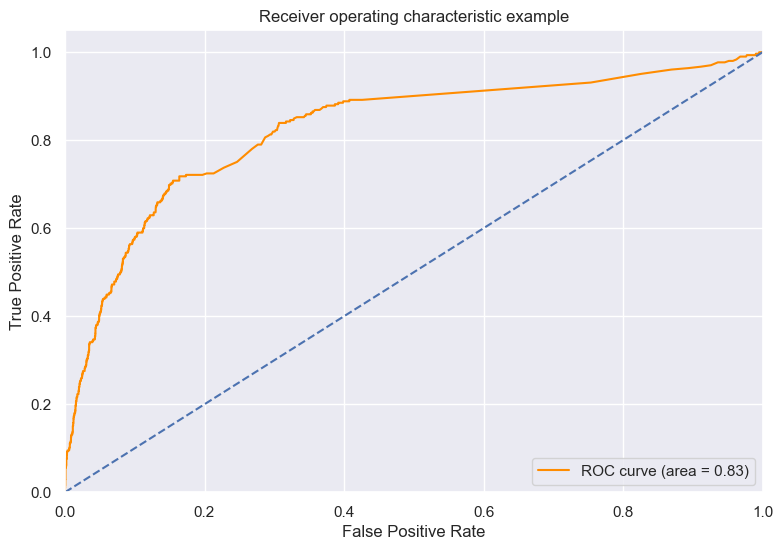

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## K-ближних

In [78]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

best_knn = grid_search_cv_clf.best_estimator_

In [79]:
best_knn.fit(X_train, y_train)

best_knn_score = best_knn.score(X_test,y_test)
print('Score =', np.round(best_knn_score, 3))

y_pred = best_knn.predict(X_test)

best_knn_precision = precision_score(y_true=y_test, y_pred=y_pred)
print('Precision =', np.round(best_knn_precision, 3))

best_knn_recall = recall_score(y_true=y_test, y_pred=y_pred)
print('Recall =', np.round(best_knn_recall, 3))

best_knn_f1 = f1_score(y_true=y_test, y_pred=y_pred)
print('F1 =', np.round(best_knn_f1, 3))

best_knn_cross_val_mean = cross_val_score(best_knn,X_train,y_train,cv=4).mean()
print('Cross_val_mean =', np.round(best_knn_cross_val_mean, 3))

print('Best_params', grid_search_cv_clf.best_params_)

Score = 0.929
Precision = 0.422
Recall = 0.125
F1 = 0.192
Cross_val_mean = 0.919
Best_params {'leaf_size': 1, 'n_neighbors': 19}


In [80]:
y_pred_prob = best_knn.predict_proba(X_test)

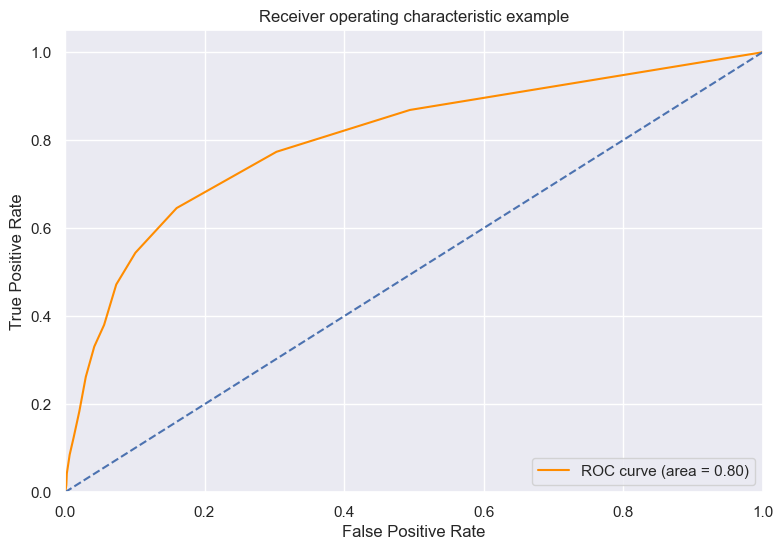

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Задания

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [83]:
submission_data = pd.read_csv('submissions_data_train.csv')
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')
submission_data['day'] = submission_data.date.dt.date
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [84]:
# Предполагается, что создатель курса будет наиболее активно проходить степы. Т.к. ему нужно будет протестировать свой курс.
users_scores = submission_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

users_scores.sort_values(['correct', 'wrong'], ascending = False).head(3)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177


В процессе решения одной аналитической задачи очень часто замечаешь и другие задачи, связанные с исследуемым вопросом. В свое время, работая над предсказанием оттока студентов со stepik, я многое изменил в структуре своих курсов. 

Тогда я нашел довольно интересную закономерность прохождения онлайн курсов. Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение. 

Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей. 

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей?

In [85]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [86]:
pd.crosstab(submission_data['step_id'], submission_data['submission_status']).sort_values('wrong', ascending=False)

submission_status,correct,wrong
step_id,,
31978,6094,16084
32031,4848,13373
32202,3948,13002
33481,2007,10300
32075,4531,10003
...,...,...
33482,1973,707
33681,1577,703
33362,2701,673
